In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, _) , (_, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_train = (X_train - 127.5)/127.5

print(X_train.min())
print(X_train.max())

-1.0
1.0


In [5]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
HALF_BATCH = 128
NO_OF_BATCHES = int(X_train.shape[0]/BATCH_SIZE)
NOISE_DIM = 100 # Upsample this into 784
adam = Adam(lr = 2e-4, beta_1 = 0.5)

In [19]:
# Generator Model : Upsampling
# 100 dim noise ---> 28,28,1

generator = Sequential()
generator.add( Dense(units = 7*7*128, input_shape=(NOISE_DIM,)) )
generator.add( Reshape((7,7,128)) )
generator.add( LeakyReLU(0.2) )
generator.add( BatchNormalization() )

# (7,7,128) ---> (14,14,64)
generator.add( Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same') )
# generator.add( UpSampling2D() )
# generator.add( Conv2D(64, kernel_size=(3,3), padding='same') )
generator.add( LeakyReLU(0.2) )
generator.add( BatchNormalization() )

# (14,14,64) --> (28,28,1)

generator.add( Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), padding='same',  activation='tanh'))
# generator.add( UpSampling2D() )
# generator.add( Conv2D(1, kernel_size=(3,3), padding='same', activation='tanh') )

generator.compile(loss="binary_crossentropy", optimizer = adam)
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)       

In [10]:
# Discriminator Model -> (Downsampling)
# (28,28,1) ---> 1 neuron


# (28,28,1) --> (14,14,64)
discriminator = Sequential()
discriminator.add( Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', input_shape = (28,28,1) ) )
discriminator.add(LeakyReLU(0.2))


# (14,14,64) ---> (7,7,128)
discriminator.add( Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same' ) )
discriminator.add( LeakyReLU(0.2))


# (7,7,128) -> 6272
discriminator.add( Flatten() )
discriminator.add( Dense(100) )
discriminator.add( LeakyReLU(0.2))

discriminator.add( Dense(1, activation='sigmoid') )

discriminator.compile(loss="binary_crossentropy", optimizer = adam)
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               627300    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 100)              

In [11]:
## Combined Model


discriminator.trainable = False



gan_input = Input(shape = (NOISE_DIM,) )

generated_img = generator(gan_input)

gan_output = discriminator(generated_img)

# Functional API
model = Model(inputs= gan_input, outputs= gan_output)
model.compile(loss="binary_crossentropy", optimizer = adam)

In [12]:
# model.summary()

In [15]:
X_train = X_train.reshape(-1, 28,28,1)

In [16]:
X_train.shape

(60000, 28, 28, 1)

In [17]:
def display_images(samples = 25):
    noise = np.random.normal(0,1, size = (samples, NOISE_DIM))
    
    generated_img = generator.predict(noise)
    
    
    plt.figure(figsize=(10,10))
    
    for i in range(samples):
        plt.subplot(5,5,i+1)
        plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
        plt.axis("off")
        
    plt.show()
    # plt.imsave("images{}.jpg".format())

Epoch 1 Disc loss 0.4422635744906898, Generator Loss 1.2034110937383957
Epoch 2 Disc loss 0.6572707429782957, Generator Loss 1.3579895980656147
Epoch 3 Disc loss 0.6201202108437179, Generator Loss 1.1210414920933545
Epoch 4 Disc loss 0.6431212209356136, Generator Loss 1.053539352491498
Epoch 5 Disc loss 0.6674653697981794, Generator Loss 0.9660158336628228
Epoch 6 Disc loss 0.66426134084025, Generator Loss 0.9238165845163167
Epoch 7 Disc loss 0.6578021071150771, Generator Loss 0.9212246066890657
Epoch 8 Disc loss 0.650649199501062, Generator Loss 0.935867432737723
Epoch 9 Disc loss 0.6448149255707732, Generator Loss 0.9647166773211211
Epoch 10 Disc loss 0.6409556689298052, Generator Loss 0.9716993365436792


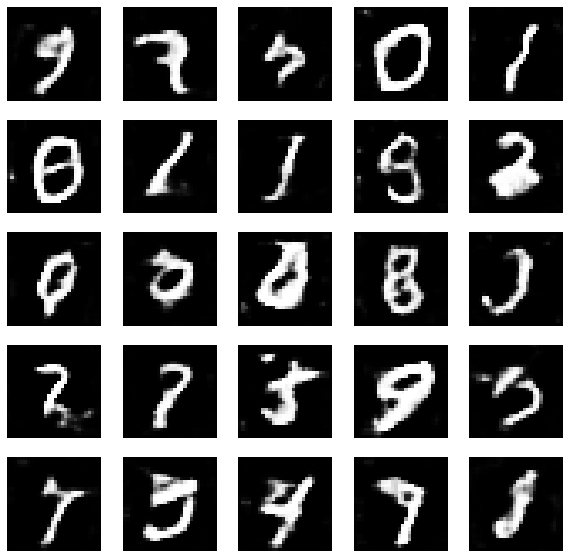

Epoch 11 Disc loss 0.6352059261666404, Generator Loss 1.001773883588612
Epoch 12 Disc loss 0.6311729743312566, Generator Loss 1.00848997104913
Epoch 13 Disc loss 0.6269512959143035, Generator Loss 1.0307413493283093
Epoch 14 Disc loss 0.6219039984111093, Generator Loss 1.0478938505984843
Epoch 15 Disc loss 0.6184488755897579, Generator Loss 1.0650808243080974
Epoch 16 Disc loss 0.6145027100912526, Generator Loss 1.0906944731250405
Epoch 17 Disc loss 0.6104162984296807, Generator Loss 1.1173686818219721
Epoch 18 Disc loss 0.6069104498268193, Generator Loss 1.127988735679537
Epoch 19 Disc loss 0.6025854180383886, Generator Loss 1.1530817127786577
Epoch 20 Disc loss 0.5983533745902216, Generator Loss 1.174778780899942


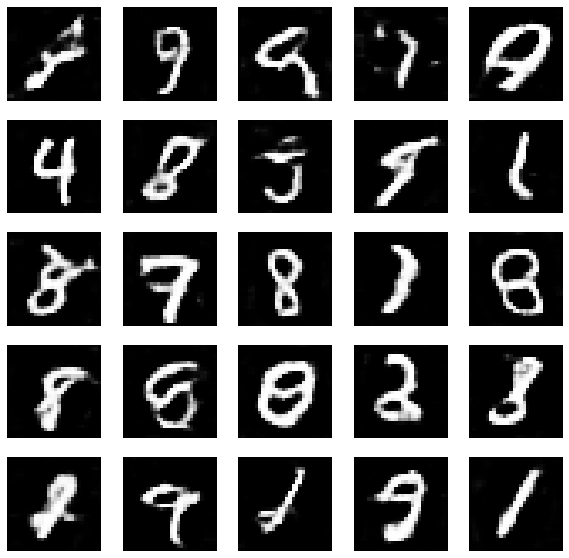

Epoch 21 Disc loss 0.5946110338609443, Generator Loss 1.1997326733544469
Epoch 22 Disc loss 0.5893491548605454, Generator Loss 1.2274253680370748
Epoch 23 Disc loss 0.5846389984218483, Generator Loss 1.252773990854621
Epoch 24 Disc loss 0.580222844822794, Generator Loss 1.2771538523957133
Epoch 25 Disc loss 0.5760999170378742, Generator Loss 1.2951899832114577
Epoch 26 Disc loss 0.5712775969479837, Generator Loss 1.323929687961936
Epoch 27 Disc loss 0.5672912552443325, Generator Loss 1.3533524223603308
Epoch 28 Disc loss 0.5626818662525243, Generator Loss 1.3759660930372775
Epoch 29 Disc loss 0.5562449633183643, Generator Loss 1.4051781413145363
Epoch 30 Disc loss 0.5524113897839164, Generator Loss 1.43520411523059


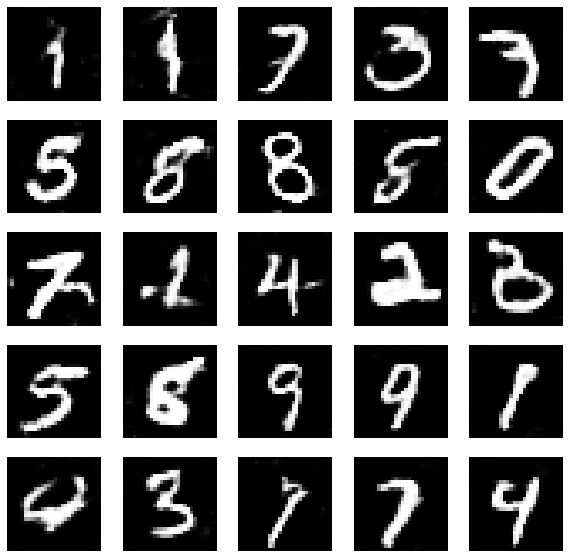

Epoch 31 Disc loss 0.5498040421014159, Generator Loss 1.466499730013311
Epoch 32 Disc loss 0.5435975400301126, Generator Loss 1.4852201477624476
Epoch 33 Disc loss 0.539763417126786, Generator Loss 1.5249483832158148
Epoch 34 Disc loss 0.5350375274180347, Generator Loss 1.5458541736006737
Epoch 35 Disc loss 0.5285869815792793, Generator Loss 1.5823137746192515
Epoch 36 Disc loss 0.5269533229561952, Generator Loss 1.614104073960334
Epoch 37 Disc loss 0.519176467616334, Generator Loss 1.6287635038606822
Epoch 38 Disc loss 0.5158322489796541, Generator Loss 1.6720911539159715
Epoch 39 Disc loss 0.5105194718791888, Generator Loss 1.6939581790938973
Epoch 40 Disc loss 0.5096679408198748, Generator Loss 1.7284707552753389


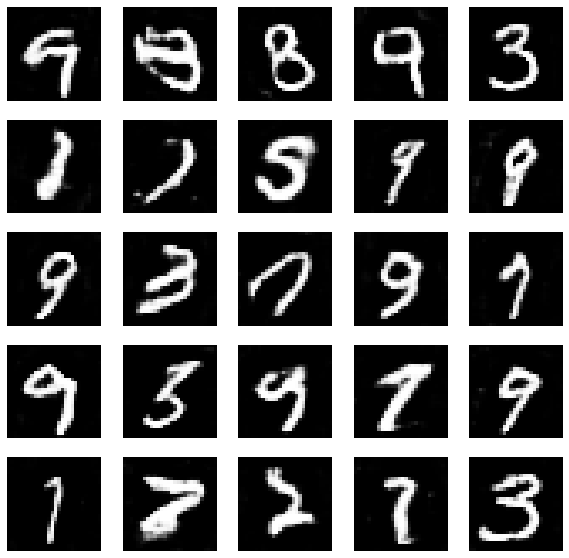

Epoch 41 Disc loss 0.5042181621249925, Generator Loss 1.7590309348888695
Epoch 42 Disc loss 0.5025725401619561, Generator Loss 1.7819920191541314
Epoch 43 Disc loss 0.4984466086468126, Generator Loss 1.8073769421316683
Epoch 44 Disc loss 0.49248634877367914, Generator Loss 1.8311373838223517
Epoch 45 Disc loss 0.4891196585491172, Generator Loss 1.871927671134472
Epoch 46 Disc loss 0.48604501236198294, Generator Loss 1.897613387554884
Epoch 47 Disc loss 0.4830828404261006, Generator Loss 1.9241859153844416
Epoch 48 Disc loss 0.4777268177041641, Generator Loss 1.949923187494278
Epoch 49 Disc loss 0.4765196852067597, Generator Loss 1.9810184952802956
Epoch 50 Disc loss 0.4749444764202986, Generator Loss 2.0097240209579468


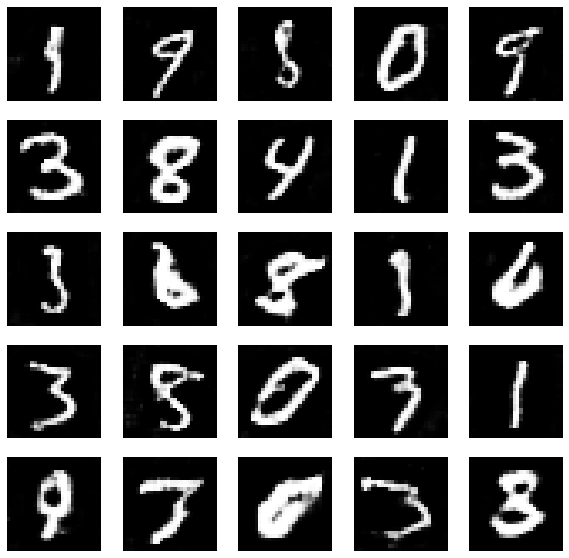

In [18]:
# TRAINING LOOP

d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):

  epoch_d_loss = 0.0
  epoch_g_loss = 0.0


  # Mini batch gradient descent
  for step in range(NO_OF_BATCHES):

    # ===========================================================================
    # Training Step -1    [Train Discriminator]
    # discriminator.trainable = True

    # Get real data 
    idx = np.random.randint(0, 60000, HALF_BATCH)
    real_imgs = X_train[idx]

    # Get fake data
    noise = np.random.normal(0, 1, size= (HALF_BATCH, NOISE_DIM) )
    fake_imgs = generator.predict(noise)

    # Labels
    real_y = np.ones((HALF_BATCH, 1))*0.9 # one-sided label smoothing
    fake_y = np.zeros((HALF_BATCH, 1))

    # now, train D
    d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)

    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss

    # ===========================================================================


    # ===========================================================================
    # Step -2 Train  Generator (Discriminator freeze)
    
    # discriminator.trainable = False

    noise = np.random.normal(0, 1, size= (BATCH_SIZE, NOISE_DIM) )
    ground_truth_y = np.ones((BATCH_SIZE, 1))

    g_loss= model.train_on_batch(noise, ground_truth_y)

    epoch_g_loss += g_loss
    # ===========================================================================


  print("Epoch {} Disc loss {}, Generator Loss {}".format((epoch+1), epoch_d_loss/NO_OF_BATCHES, epoch_g_loss/BATCH_SIZE))

  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)

  if(epoch+1)%10==0:
    generator.save("generator.h5")
    display_images()